In [1]:
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import pickle 

# Function to generate bin edges using ppm
def bin_ppm(min_val, max_val, ppm):
    value = min_val
    bin_edges = []
    while value < max_val:
        bin_edges.append(value)
        value = value * (1 + ppm/1000000)
    
    return bin_edges


# Function to generate bin edges using constant bin size
def bin_linear(min_val, max_val, size):
    bin_edges = np.arange(min_val, max_val+size, size)
    
    return bin_edges


# Function to normalize RT values
def normalize_rt(group):
    # Convert RT to numeric, setting non-convertible values to NaN. 
    # This is to allow RTs to be unspecified.
    rt_numeric = pd.to_numeric(group['RT'], errors='coerce')
    
    # Perform normalization
    max_rt = max(rt_numeric.max(), 30)
    normalized_values = rt_numeric / max_rt
    group['RT'].loc[rt_numeric.notna()] = normalized_values

    return group


# Function to bin RT 
def rt_binning(rt_value, RT_bin_edges):
    if isinstance(rt_value, (int, float)):
        # Bin the numeric value
        binned_index = np.digitize([rt_value], RT_bin_edges)[0]
        return f'rt{binned_index}'
    else:
        # Return string value, for example unspecified
        return str(rt_value)
    
    
# Function to bin MZ 
def mz_binning(mz_values, bin_edges):
    binned_indices = np.digitize(mz_values, bin_edges)
    return ['mz' + str(index) for index in binned_indices]


# Function to bin peaks 
def peak_binning(peak_values, bin_edges):
    binned_indices = np.digitize(peak_values, bin_edges)
    return ['pk' + str(index) for index in binned_indices]


# Function to process, normalize, sort the dictionary, and bin both keys and values
def process_peak_d(dict_string, mz_bin_edges, peak_bin_edges, threshold):
    try:
        # convert peak_d to dictionary
        dict_data = ast.literal_eval(dict_string) 
    except ValueError:
        return [], []

    # Normalize and threshold peak intensity 
    total = sum(dict_data.values())
    normalized_dict = {k: v / total for k, v in dict_data.items() if (v / total) > threshold}
    
    # Sort and bin the peaks
    sorted_dict = dict(sorted(normalized_dict.items(), key=lambda item: item[1], reverse=True))
    mzs = list(sorted_dict.keys())
    peaks = list(sorted_dict.values())
    binned_mzs = mz_binning(mzs, mz_bin_edges)
    binned_peaks = peak_binning(peaks, peak_bin_edges)

    return binned_mzs, binned_peaks


# Function to process data
def process_data(df, RT_bin_edges, mz_bin_edges, peak_bin_edges, threshold):

    # Normalize RTs from each file
    df = df.groupby('filename', group_keys=False).apply(normalize_rt)

    # Get RT bin indices
    df['binned_RT'] = df['RT'].apply(lambda x: rt_binning(x, RT_bin_edges))
    
    # Get m/z bin index for precursor mass
    df['binned_mass'] = df['reducing_mass'].apply(lambda x: 'mz' + str(np.digitize(x, mz_bin_edges)))
    
    # Process peak_d column
    df['processed_peak_d'] = df['peak_d'].apply(lambda x: process_peak_d(x, mz_bin_edges, peak_bin_edges, threshold))

    # Get m/z and peak bin indices
    df['binned_mz'] = df['processed_peak_d'].apply(lambda x: x[0])
    df['binned_peak'] = df['processed_peak_d'].apply(lambda x: x[1])

    return df


# Function to generate corpus
def generate_corpus_mz(df):

    # Construct sentences
    corpus = pd.DataFrame()
    corpus['sentence'] = df[['LC_type', 'mode', 'ionization', 'modification', 'trap', 'fragmentation', 'glycan_type', 'binned_RT', 'binned_mass']].agg(' '.join, axis=1)
    corpus['sentence'] += ' ' + df['binned_mz'].apply(' '.join)

    return corpus['sentence'].tolist()

def generate_corpus_mz_peak(df):

    # Function to interleave mz and peak values
    def interleave_mz_peak(mz, peak):
        paired = [f"{m} {p}" for m, p in zip(mz, peak)]
        return ' '.join(paired)

    # Construct sentences
    corpus = pd.DataFrame()
    corpus['sentence'] = df[['LC_type', 'mode', 'ionization', 'modification', 'trap', 'fragmentation', 'glycan_type', 'binned_RT', 'binned_mass']].agg(' '.join, axis=1)
    corpus['sentence'] += ' ' + df.apply(lambda x: interleave_mz_peak(x['binned_mz'], x['binned_peak']), axis=1)

    return corpus['sentence'].tolist()


In [2]:
# Load data
dataDir = '/Users/rudi/Data/CandyCrunch/Apr2024/'
fulldata_file = ''.join([dataDir, 'training.xlsx'])

# Load full dataset
df_raw = pd.read_excel(fulldata_file)

In [2]:
# Settings for binning
threshold = 0.001 #peak intensity thresholding

minMZ = 39.714 #minimum m/z
maxMZ = 3000 #maximum m/z
sizeMZ = 0.3 #m/z bin size
mz_bin_edges = bin_linear(minMZ, maxMZ, sizeMZ) #use linear binning
#mz_bin_edges = bin_ppm(minMZ, maxMZ, 20) #use ppm binning

minI = 0
maxI = 1
sizeI = 0.001 #peak intensity bin size
peak_bin_edges = bin_linear(minI, maxI, sizeI)

minRT = 0
maxRT = 1
sizeRT = 0.01 #relative retention time bin size
RT_bin_edges = bin_linear(minRT, maxRT, sizeRT)

print('Number of bins: ', len(mz_bin_edges))

Number of bins:  9869


In [4]:
# Process data
df = process_data(df_raw, RT_bin_edges, mz_bin_edges, peak_bin_edges, threshold)


In [7]:
np.digitize(500, mz_bin_edges)

1535

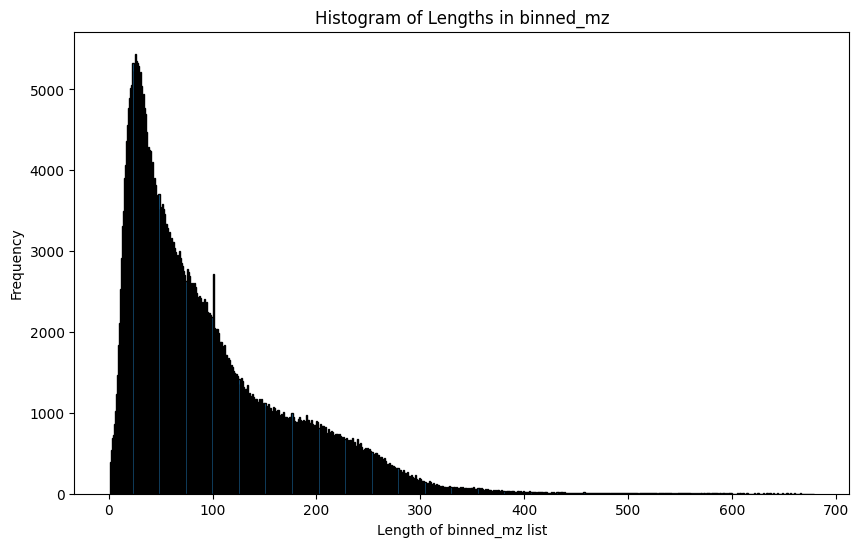

Number of spectra with more than 512 peaks: 342


In [5]:
# Assess the frequencies of mz bins in dataset

import pandas as pd
import matplotlib.pyplot as plt

# Output data of mz bins seen in the dataset 
flattened_list = [item for sublist in df['binned_mz'] for item in sublist]
unique_elements = set(flattened_list)
sorted_unique_elements = sorted(list(unique_elements))
sorted_df = pd.DataFrame(sorted_unique_elements, columns=['Unique Elements'])
csv_file_path = 'sorted_mz_elements.csv'
sorted_df.to_csv(csv_file_path, index=False)

# Get histogram of spectra length
lengths = df['binned_mz'].apply(len)

# Plotting the histogram
plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
plt.hist(lengths, bins=range(1, lengths.max() + 1), edgecolor='black')
plt.title('Histogram of Lengths in binned_mz')
plt.xlabel('Length of binned_mz list')
plt.ylabel('Frequency')

# Show the plot
plt.show()

count = (lengths > 512).sum()
print(f"Number of spectra with more than 512 peaks: {count}")


In [6]:
# Prepare vocabulary
# Initialize an empty set to store unique words
words = set()

# Loop through each specified column
for column in ['LC_type', 'mode', 'ionization', 'modification', 'trap', 'fragmentation', 'glycan_type']:
    # Extract unique values from the column and put them into words
    words.update(df[column].astype(str).dropna().unique())

# Convert the set to a list
words = list(words)

# Prepare vocabulary for m/z
for index in range(0, len(mz_bin_edges) + 1):
    words.append('mz' + str(index))
    
# Prepare vocabulary for retention time
for index in range(0, len(RT_bin_edges) + 1):
    words.append('rt' + str(index))
    
# Write the unique words to a file
with open('vocab.txt', 'w') as file:
    for word in sorted(words):
        file.write(word + '\n')

print(f"Vocabulary file created with {len(words)} words.")


Vocabulary file created with 10005 words.


In [7]:
# Prepare glycan class labels

# Get the value counts of unique glycans
glycan_labels = df['glycan'].value_counts()

# Reset the index to turn it into a DataFrame
glycan_labels = glycan_labels.reset_index()
glycan_labels.columns = ['glycan', 'frequency']
glycan_labels = glycan_labels.sort_values(by='glycan')
glycan_labels = glycan_labels.reset_index()

# Create a mapping from glycans to their labels (indices)
glycan_to_label = {row['glycan']: idx for idx, row in glycan_labels.iterrows()}

# Map each glycan in df to its corresponding label
df['class_label'] = df['glycan'].map(glycan_to_label)

# Display the first few rows of the DataFrame with class labels
print('Number of glycan classes: ', len(glycan_labels))

glycan_labels_df = pd.DataFrame(list(glycan_to_label.items()), columns=['glycan', 'label'])

# Define the file path for the Excel file
excel_out = ''.join([dataDir, 'glycans.xlsx'])  # Replace with your desired file path

# Save the DataFrame to an Excel file
glycan_labels_df.to_excel(excel_out, index=False)


Number of glycan classes:  3590


In [8]:
# Split into train and test
train_df, test_df = train_test_split(df, test_size=0.15, random_state=0)

# Find class_labels present in test but not in train
labels_train = set(train_df['class_label'])
labels_test = set(test_df['class_label'])
labels_move = labels_test - labels_train

# Move rows with these labels from test to train
rows_to_move = test_df[test_df['class_label'].isin(labels_move)]
train_df = pd.concat([train_df, rows_to_move])
test_df = test_df[~test_df['class_label'].isin(labels_move)]

# Now, train_df and test_df are your final DataFrames
print('Size of train set: ', len(train_df))
print('Size of test set: ', len(test_df))

Size of train set:  428074
Size of test set:  75372


In [9]:
# Generate corpus for model training
sentences = generate_corpus_mz(train_df)

with open('train_corpus_mz.txt', 'w') as file:
    for sentence in sentences:
        file.write(sentence + '\n')

print("Train sentences saved to train_corpus_mz.txt")

sentences = generate_corpus_mz(test_df)

with open('test_corpus_mz.txt', 'w') as file:
    for sentence in sentences:
        file.write(sentence + '\n')

print("Test sentences saved to test_corpus_mz.txt")

Train sentences saved to train_corpus_mz.txt
Test sentences saved to test_corpus_mz.txt


In [10]:
# Save train and test glycan class label

train_labels = train_df['class_label'].tolist()
test_labels = test_df['class_label'].tolist()

train_label_path = 'train_label.pkl'  # Define the path for the train labels pickle file
test_label_path = 'test_label.pkl'  # Define the path for the test labels pickle file

# Save to pickle files
with open(train_label_path, 'wb') as file:
    pickle.dump(train_labels, file)

# Save test_labels list to a pickle file
with open(test_label_path, 'wb') as file:
    pickle.dump(test_labels, file)


In [11]:
# Generate corpus for model training using full dataset
sentences = generate_corpus_mz(df)

with open('corpus_mz.txt', 'w') as file:
    for sentence in sentences:
        file.write(sentence + '\n')

print("Final set of sentences saved to corpus_mz.txt")

Final set of sentences saved to corpus_mz.txt


In [12]:
# Load glycan labels
glycans_file = ''.join([dataDir, 'glycans.xlsx'])
glycans_df = pd.read_excel(glycans_file)

# Create a mapping from glycans to their labels (indices)
glycan_to_label = {row['glycan']: row['label'] for i, row in glycans_df.iterrows()}

# Map each glycan in df to its corresponding label
df['class_label'] = df['glycan'].map(glycan_to_label)
labels = df['class_label'].tolist()

# Save labels list to a pickle file
label_file = 'label.pkl'
with open(label_file, 'wb') as file:
    pickle.dump(labels, file)
